# LC-MS: MS identified Features Pos 


In [2]:
import pandas as pd
import numpy as np
import os
import openpyxl

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt


from itertools import combinations
from sklearn.decomposition import PCA
from scipy.stats import zscore, entropy, f_oneway, kruskal
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.cross_decomposition import CCA


from sklearn.ensemble import IsolationForest

%matplotlib inline

In [3]:
# set the directory 
os.chdir('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/Results')

In [4]:
# Define the color palette for the sample types
sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

sns.set_style(style="whitegrid")


# 1. Load data

In [5]:
# order
samples = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/Order_34707_orderitem.csv')

# Extract the list of sample names
sample_names = samples['Sample Name'].tolist()
# Create a new dataframe 'sample_md' with selected column
sample_md = samples[['Sample Name']].copy()
# Split 'Sample Name' into new columns
sample_md[['sample_type', 'year', 'plot']] = sample_md['Sample Name'].str.split('_', expand=True)
sample_md.head()

,Sample Name,sample_type,year,plot
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17


In [6]:
# Get the raw data
file_path_MS1MS2 = "/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/p32837_o34707_Lena_RPMetabolomics_MS1_MS2_Features_POS.xlsx"
file_path_MS2 = "/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/p32837_o34707_Lena_RPMetabolomics_MS2_Features_POS.xlsx"

# Read only the 'Area_Stats' sheet
df_MS1MS2 = pd.read_excel(file_path_MS1MS2, sheet_name="Compounds")
df_MS2 = pd.read_excel(file_path_MS2, sheet_name="Compounds")

In [7]:
print('MS1/MS2')
print('Uniquely annotated features: ' + str(df_MS1MS2['Name'].notna().sum()))

MS1/MS2
Uniquely annotated features: 1942


In [8]:
print('MS2')
print('Uniquely annotated features: ' + str(df_MS2['Name'].notna().sum()))


MS2
Uniquely annotated features: 191


# MS1/MS2 Data prep

In [9]:
# Identify 'Norm. Area' columns that correspond to samples in the list
matching_columns = [
    col for col in df_MS1MS2.columns
    if any(sample in col for sample in sample_names) and col.startswith('Norm. Area')] # Create a mapping to rename columns by extracting only the sample name
rename_dict = {col: next(sample for sample in sample_names if sample in col) for col in matching_columns}
# Select relevant columns and rename them
df_MS1MS2 = df_MS1MS2[['Name'] + matching_columns].rename(columns=rename_dict)

# Set 'Name' as the index
df_MS1MS2.set_index('Name', inplace=True)

df_MS1MS2.head()

,Must_2023_Plot20,Must_2023_Plot19,Must_2023_Plot14,Must_2023_Plot17,Must_2023_Plot4,Must_2023_Plot9,Must_2023_Plot5,Must_2023_Plot12,Must_2023_Plot13,Must_2023_Plot15,...,PostMLF_2023_Plot4,PostMLF_2023_Plot15,PostMLF_2023_Plot5,PostMLF_2023_Plot20,PostMLF_2023_Plot17,PostMLF_2023_Plot13,PostMLF_2023_Plot14,PostMLF_2023_Plot19,PostMLF_2023_Plot9,PostMLF_2023_Plot12
Name,,,,,,,,,,,,,,,,,,,,,
(+)-6-epi-stephacidin A,2.452444e+06,5.977890e+06,4.965362e+06,3.568963e+06,1.896338e+06,3.901788e+06,998199.948892,7.667300e+05,1.090463e+07,4.678563e+06,...,3.845615e+05,2.868514e+05,3.626115e+05,3.209940e+05,3.119926e+05,3.224940e+05,4.505075e+05,3.485536e+05,3.349212e+05,3.654243e+05
(+)-ochromycinone,2.062990e+06,3.966040e+05,2.880246e+05,2.857134e+05,3.441172e+05,3.269570e+05,261729.132228,1.227715e+06,1.139577e+06,1.525091e+06,...,1.240650e+06,1.460656e+06,3.471103e+06,2.527094e+06,1.478378e+06,1.323790e+06,4.558595e+06,2.682822e+06,3.650059e+06,2.758317e+06
(+)-ochromycinone,5.617105e+05,5.689648e+05,6.224863e+05,6.285945e+05,5.463372e+05,6.109600e+05,835514.441104,6.050893e+05,5.352703e+05,6.012999e+05,...,3.711890e+05,6.077888e+05,4.979913e+05,8.730306e+05,2.405520e+05,4.967972e+05,6.652335e+05,2.684821e+05,1.000749e+06,9.979660e+05
"(-)-11-hydroxy-9,10-dihydrojasmonic acid 11-beta-D-glucoside",5.053455e+05,4.728770e+05,4.914848e+05,4.721601e+05,4.812727e+05,4.130656e+05,564049.759062,5.839707e+05,4.553689e+05,4.276669e+05,...,1.256574e+06,2.193709e+06,2.609997e+06,4.791159e+06,3.959975e+06,1.713959e+06,6.100833e+05,1.226932e+06,1.160843e+06,2.668588e+06
(-)-Lamivudine,4.261175e+05,4.211507e+05,4.263197e+05,4.336634e+05,4.325973e+05,4.267036e+05,479727.477098,4.878481e+05,4.186408e+05,3.915918e+05,...,5.496699e+05,1.892717e+05,2.104156e+05,2.573830e+05,1.695805e+05,4.012460e+05,5.188223e+05,1.574874e+05,3.400152e+05,1.653059e+05


In [10]:
## MERGE samples with metadata
df_MS1MS2 = df_MS1MS2.T  # Transpose so samples are rows, features are columns
df_MS1MS2.index.name = 'Sample Name'

# Merge metadata with metabolomics data
df_MS1MS2_wMetadata = sample_md.merge(df_MS1MS2, on='Sample Name')

df_MS1MS2_wMetadata.head()

,Sample Name,sample_type,year,plot,(+)-6-epi-stephacidin A,(+)-ochromycinone,(+)-ochromycinone,"(-)-11-hydroxy-9,10-dihydrojasmonic acid 11-beta-D-glucoside",(-)-Lamivudine,(-)-Lamivudine,...,α-Aspartylphenylalanine,α-Aspartylphenylalanine,α-Dehydrobiotin,α-Lactose,α-Methylbiotin,γ-L-glutaminyl-4-hydroxybenzene,γ-L-glutaminyl-4-hydroxybenzene,γ-L-glutamyl-L-leucine,γ-L-glutamyl-L-leucine,γ-Linolenic acid ethyl ester
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14,4.384093e+05,2.330807e+06,9.928892e+05,270839.369426,373255.010883,140346.885288,...,3.477252e+05,2.307151e+06,5.185013e+05,2.296109e+07,266586.780980,251072.362101,4.410323e+05,4.263337e+06,1.322909e+06,4.173555e+05
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9,3.859082e+05,1.226509e+06,6.799517e+05,226526.688277,545395.249863,166820.584064,...,3.858248e+05,1.483529e+06,3.972452e+05,1.512257e+07,247323.219520,398778.250662,7.931905e+05,6.183243e+06,1.323540e+06,3.993300e+05
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15,3.619557e+05,2.535004e+06,1.573465e+06,197658.908789,264200.472600,128610.466669,...,2.608673e+05,1.218210e+06,4.567842e+05,1.592785e+07,225365.199301,230675.566115,3.620907e+05,4.230207e+06,1.438127e+07,4.055137e+05
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12,1.032186e+06,3.538351e+05,8.364432e+05,670464.433303,520830.779350,445447.911034,...,7.083360e+05,9.720946e+05,1.386647e+06,1.368166e+06,806934.139860,234766.960041,8.525567e+05,2.969781e+05,3.918385e+05,1.172564e+06
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17,3.215328e+05,2.394133e+06,1.185855e+06,222395.578179,768469.556487,286756.235524,...,2.356091e+06,2.163101e+06,3.984899e+05,1.621637e+07,231598.531579,502487.358990,1.201365e+06,7.555596e+06,1.314372e+06,3.369838e+05


### Alpha Diversity 
> check before normalizing 

#### Shannon Entropy

In [11]:
# Shannon entropy calculation
def shannon_entropy(values):
    """Calculate Shannon entropy for a given array of values."""
    # Normalize the values to get probabilities
    value_counts = values.value_counts(normalize=True)
    return entropy(value_counts)

# Function to apply Shannon entropy to the dataframe
def shannon_diversity_df(df):
    """Calculate Shannon Diversity for each column in a DataFrame."""
    shannon_diversity_values = {}
    for column in df.columns:
        shannon_diversity_values[column] = shannon_entropy(df[column])
    return pd.Series(shannon_diversity_values)

In [12]:
 # Apply Shannon entropy calculation to the collapsed data
shannon_diversity_results = df_MS1MS2_wMetadata.apply(shannon_entropy, axis=1)

# Add the Shannon diversity values to a new dataframe with 'Sample Type' and 'Year'
shannon_diversity_df = pd.DataFrame({
    'Sample Type': df_MS1MS2_wMetadata['sample_type'],  # Assuming 'sample_type' is a column
    'Year': df_MS1MS2_wMetadata['year'],  # Assuming 'year' is a column
    'Shannon Diversity': shannon_diversity_results
})

In [13]:
# Group by 'Year' and 'Sample Type' for Shannon index
shannon_grouped = shannon_diversity_df.groupby(['Year', 'Sample Type'])['Shannon Diversity']

# Extract values for each group
group_postMLF_2023_shannon = shannon_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_shannon = shannon_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_shannon = shannon_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('SHANNON postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2022_shannon)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2021_shannon)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2022_shannon, group_postMLF_2021_shannon)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

SHANNON postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.14366799468389907
ANOVA 2023 vs 2021 p-value: 0.4160186843549515
ANOVA 2022 vs 2021 p-value: 0.7930384173491757


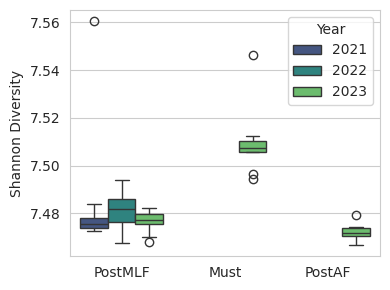

In [14]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=shannon_diversity_df, x='Sample Type', y='Shannon Diversity', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Shannon Diversity')
plt.legend(title='Year')
plt.tight_layout() 
plt.show()

#### Richness

In [14]:
def richness(df):
    """Calculate richness (number of unique values) for each row in the DataFrame."""
    return df.apply(lambda x: x.nunique(), axis=1)

In [15]:
# Calculate richness for each sample (row)
richness_values = richness(df_MS1MS2_wMetadata.iloc[:, 3:])

# Create a DataFrame with richness values
richness_df = pd.DataFrame(richness_values, columns=['Richness']).reset_index()

# Extract 'Sample Type' and 'Year' from the index or metadata columns
richness_df['Sample Type'] = df_MS1MS2_wMetadata['sample_type'].values
richness_df['Year'] = df_MS1MS2_wMetadata['year'].values

In [16]:
richness_grouped = richness_df.groupby(['Year', 'Sample Type'])['Richness']

# Extract values for each group
group_postMLF_2023_values = richness_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_values = richness_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_values = richness_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('RICHNESS postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2022_values)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2021_values)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2022_values, group_postMLF_2021_values)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

RICHNESS postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.12046527559560179
ANOVA 2023 vs 2021 p-value: 0.40555112540635174
ANOVA 2022 vs 2021 p-value: 0.8182467629760436


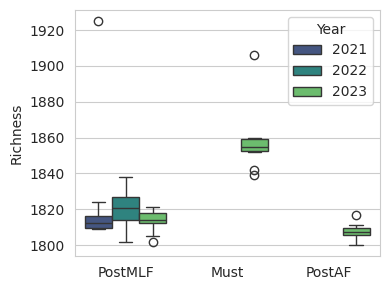

In [17]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=richness_df, x='Sample Type', y='Richness', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Richness')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Normalize & Transform Data

1. Log Transformation to reduce skewness.
2. Pareto/Auto-scaling (Z-score normalization) for better comparison.

In [15]:
df_MS1MS2_wMetadata.iloc[:, 4:] = np.log1p(df_MS1MS2_wMetadata.iloc[:, 4:])  # Log transform
scaler = StandardScaler()
df_MS1MS2_wMetadata.iloc[:, 4:] = scaler.fit_transform(df_MS1MS2_wMetadata.iloc[:, 4:])

df_MS1MS2_wMetadata.set_index('Sample Name', inplace=True)

In [16]:
df_MS1MS2_wMetadata.shape

(52, 1945)

### Remove outliers

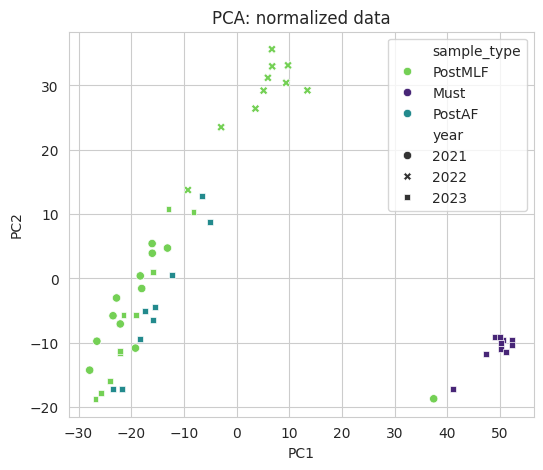

In [17]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_MS1MS2_wMetadata.iloc[:, 3:])

df_pca = df_MS1MS2_wMetadata[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette=sample_type_palette)
plt.title('PCA: normalized data')
plt.show()


The Post-MLF 2021 samples appear to be outliers - we apply an Isolation Forest to clear this up

> Alternative: Apply Isolation Forest on PCA Scores? 

In [18]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df_MS1MS2_wMetadata.iloc[:, 4:])  # Fit on normalized data

# Remove outliers (label = -1)
df_MS1MS2_wMetadata_cleaned = df_MS1MS2_wMetadata[outlier_labels == 1]
df_MS1MS2_wMetadata_cleaned.shape

(49, 1945)

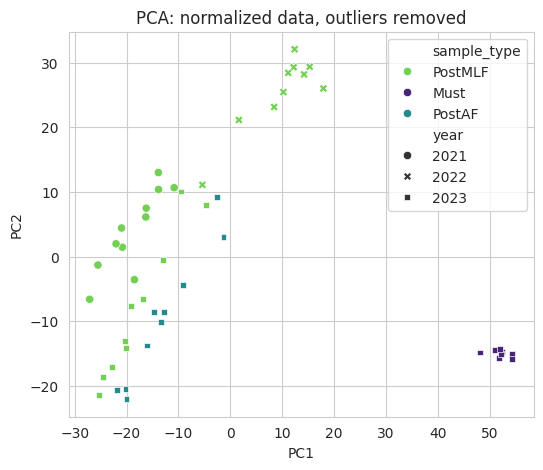

In [19]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_MS1MS2_wMetadata_cleaned.iloc[:, 3:])

df_pca = df_MS1MS2_wMetadata_cleaned[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette = sample_type_palette)
plt.title('PCA: normalized data, outliers removed')
plt.show()


In [20]:
# save
df_MS1MS2_wMetadata_cleaned.to_csv('Pos_MS1MS2_OutlierRemoved.csv')

# MS2 Data prep

In [24]:
# Identify 'Norm. Area' columns that correspond to samples in the list
matching_columns = [
    col for col in df_MS2.columns
    if any(sample in col for sample in sample_names) and col.startswith('Norm. Area')] # Create a mapping to rename columns by extracting only the sample name
rename_dict = {col: next(sample for sample in sample_names if sample in col) for col in matching_columns}
# Select relevant columns and rename them
df_MS2 = df_MS2[['Name'] + matching_columns].rename(columns=rename_dict)

# Set 'Name' as the index
df_MS2.set_index('Name', inplace=True)

df_MS2.head()

,Must_2023_Plot20,Must_2023_Plot19,Must_2023_Plot14,Must_2023_Plot17,Must_2023_Plot4,Must_2023_Plot9,Must_2023_Plot5,Must_2023_Plot12,Must_2023_Plot13,Must_2023_Plot15,...,PostMLF_2023_Plot4,PostMLF_2023_Plot15,PostMLF_2023_Plot5,PostMLF_2023_Plot20,PostMLF_2023_Plot17,PostMLF_2023_Plot13,PostMLF_2023_Plot14,PostMLF_2023_Plot19,PostMLF_2023_Plot9,PostMLF_2023_Plot12
Name,,,,,,,,,,,,,,,,,,,,,
"1,2-Di-(9Z,12Z,15Z-octadecatrienoyl)-sn-glycero-3-phosphocholine",4.356174e+06,5.920058e+06,3.797972e+06,4.391612e+06,3.201504e+06,3.723695e+06,2.159396e+05,6.984376e+05,6.336525e+06,6.120732e+06,...,78234.531959,6.626184e+04,77952.748821,6.874460e+04,6.100847e+04,70218.845842,8.690711e+04,69906.466913,85202.120711,71180.393702
"1,2-Dilinoleoyl-sn-glycero-3-phosphocholine",2.399070e+07,3.865931e+07,2.134222e+07,1.186262e+07,1.337554e+07,1.200194e+07,4.267579e+05,1.858522e+05,4.277780e+07,3.542555e+07,...,152512.437510,1.291396e+05,161672.432813,1.339154e+05,1.213084e+05,129611.012794,1.773950e+05,144982.533547,164482.244179,135922.703337
"1,2-Dipalmitoleoyl-sn-glycero-3-phosphocholine",1.348493e+06,1.722694e+06,1.543725e+06,9.853890e+05,1.518505e+06,1.663454e+06,3.949921e+05,3.881426e+05,4.751668e+06,3.574179e+06,...,147458.691279,1.277989e+05,151474.239853,1.358346e+05,1.198209e+05,119261.253097,1.666281e+05,122698.224818,166188.766323,143941.835733
"1,5-Naphthalenediamine",1.126787e+07,1.394935e+07,5.231169e+06,1.007727e+07,7.430810e+06,1.201650e+07,7.512700e+05,5.523551e+06,1.093939e+07,4.663333e+06,...,251539.913991,2.313688e+05,275942.047537,2.151097e+05,1.779852e+05,211904.939079,2.812705e+05,235213.363617,258253.270317,231733.074085
"1,6-ANHYDRO-B-GLUCOSE",4.602828e+07,3.909564e+07,4.807289e+07,4.570602e+07,4.346419e+07,4.708589e+07,2.784245e+07,3.807561e+07,3.982630e+07,4.383397e+07,...,969868.414473,1.331276e+06,857609.165660,1.002656e+06,1.237962e+06,739787.426641,1.042305e+06,773801.352318,902332.809895,827952.184613


In [25]:
## MERGE samples with metadata
df_MS2 = df_MS2.T  # Transpose so samples are rows, features are columns
df_MS2.index.name = 'Sample Name'

# Merge metadata with metabolomics data
df_MS2_wMetadata = sample_md.merge(df_MS2, on='Sample Name')

df_MS2_wMetadata.head()

,Sample Name,sample_type,year,plot,"1,2-Di-(9Z,12Z,15Z-octadecatrienoyl)-sn-glycero-3-phosphocholine","1,2-Dilinoleoyl-sn-glycero-3-phosphocholine","1,2-Dipalmitoleoyl-sn-glycero-3-phosphocholine","1,5-Naphthalenediamine","1,6-ANHYDRO-B-GLUCOSE","1-(3,4-dimethoxyphenyl)ethan-1-one oxime",...,Val-Leu,Val-Ser,Val-Val,Valylproline,VLK,VLK,Xanthine,YLK,α-Aspartylphenylalanine,α-Aspartylphenylalanine
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14,84322.121586,132741.301386,137853.674155,301624.146896,9.825509e+05,2.117948e+06,...,1.498541e+06,3.224544e+06,8.255304e+06,8.774170e+06,4.996468e+05,363418.178884,1.276678e+07,256439.639808,3.477252e+05,2.307151e+06
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9,73866.933103,133006.498960,166690.015348,255083.289697,8.654675e+05,1.354602e+06,...,3.338981e+06,4.003704e+06,1.608518e+07,7.253591e+06,1.431383e+06,319897.476083,1.282845e+07,270049.157351,3.858248e+05,1.483529e+06
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15,73736.489556,148725.900036,139850.922088,271491.205022,9.027298e+05,2.865847e+06,...,1.707459e+06,3.484498e+06,7.889962e+06,6.276211e+06,2.204592e+06,283552.188848,1.141981e+07,250060.002752,2.608673e+05,1.218210e+06
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12,256258.871178,589857.035179,492154.699900,748056.210446,1.989633e+06,2.652859e+05,...,1.718015e+06,2.552716e+05,1.624485e+06,2.794550e+05,9.811012e+05,855627.654376,2.678594e+05,760845.576191,7.083360e+05,9.720946e+05
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17,64611.941843,138558.488195,131212.401815,269801.576740,7.847789e+05,2.532542e+06,...,7.754409e+06,5.483113e+06,4.747655e+06,8.014841e+06,3.671239e+05,266533.742464,8.928180e+06,234733.132059,2.356091e+06,2.163101e+06


### Alpha Diversity 
> check before normalizing 

#### Shannon Entropy

In [26]:
 # Apply Shannon entropy calculation to the collapsed data
shannon_diversity_results = df_MS2_wMetadata.apply(shannon_entropy, axis=1)

# Add the Shannon diversity values to a new dataframe with 'Sample Type' and 'Year'
shannon_diversity_df = pd.DataFrame({
    'Sample Type': df_MS2_wMetadata['sample_type'],  # Assuming 'sample_type' is a column
    'Year': df_MS2_wMetadata['year'],  # Assuming 'year' is a column
    'Shannon Diversity': shannon_diversity_results
})

In [27]:
# Group by 'Year' and 'Sample Type' for Shannon index
shannon_grouped = shannon_diversity_df.groupby(['Year', 'Sample Type'])['Shannon Diversity']

# Extract values for each group
group_postMLF_2023_shannon = shannon_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_shannon = shannon_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_shannon = shannon_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('SHANNON postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2022_shannon)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2021_shannon)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2022_shannon, group_postMLF_2021_shannon)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

SHANNON postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.06723785329004345
ANOVA 2023 vs 2021 p-value: 0.1123716564507537
ANOVA 2022 vs 2021 p-value: 0.3387195028884974


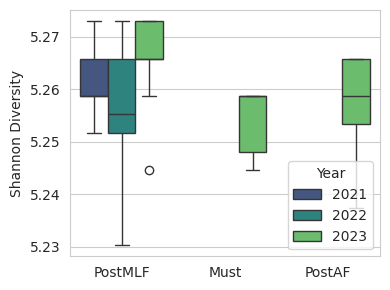

In [28]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=shannon_diversity_df, x='Sample Type', y='Shannon Diversity', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Shannon Diversity')
plt.legend(title='Year')
plt.tight_layout() 
plt.show()

#### Richness

In [29]:
# Calculate richness for each sample (row)
richness_values = richness(df_MS2_wMetadata.iloc[:, 3:])

# Create a DataFrame with richness values
richness_df = pd.DataFrame(richness_values, columns=['Richness']).reset_index()

# Extract 'Sample Type' and 'Year' from the index or metadata columns
richness_df['Sample Type'] = df_MS2_wMetadata['sample_type'].values
richness_df['Year'] = df_MS2_wMetadata['year'].values

In [30]:
richness_grouped = richness_df.groupby(['Year', 'Sample Type'])['Richness']

# Extract values for each group
group_postMLF_2023_values = richness_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_values = richness_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_values = richness_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('RICHNESS postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2022_values)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2021_values)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2022_values, group_postMLF_2021_values)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

RICHNESS postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.06723785329004857
ANOVA 2023 vs 2021 p-value: 0.11237165645076491
ANOVA 2022 vs 2021 p-value: 0.3387195028884933


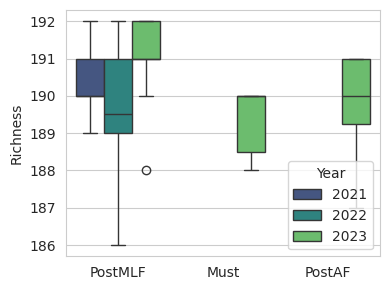

In [31]:
# Plot box plots
sns.set_style(style="whitegrid")
plt.figure(figsize=(4, 3))
sns.boxplot(data=richness_df, x='Sample Type', y='Richness', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Richness')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Normalize & Transform Data

1. Log Transformation to reduce skewness.
2. Pareto/Auto-scaling (Z-score normalization) for better comparison.

In [32]:
df_MS2_wMetadata.iloc[:, 4:] = np.log1p(df_MS2_wMetadata.iloc[:, 4:])  # Log transform
scaler = StandardScaler()
df_MS2_wMetadata.iloc[:, 4:] = scaler.fit_transform(df_MS2_wMetadata.iloc[:, 4:])

df_MS2_wMetadata.set_index('Sample Name', inplace=True)

In [33]:
df_MS2_wMetadata.shape

(52, 194)

### Remove outliers

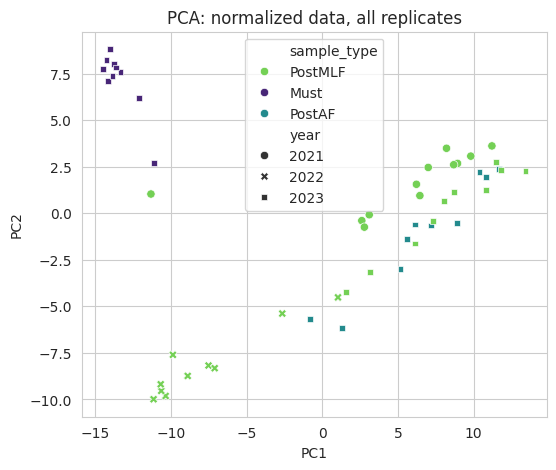

In [ ]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_MS2_wMetadata.iloc[:, 3:])

df_pca = df_MS2_wMetadata[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette=sample_type_palette)
plt.title('PCA: normalized data')
plt.show()


The Post-MLF 2021 samples appear to be outliers - we apply an Isolation Forest to clear this up

> Alternative: Apply Isolation Forest on PCA Scores? 

In [35]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df_MS2_wMetadata.iloc[:, 4:])  # Fit on normalized data

# Remove outliers (label = -1)
df_MS2_wMetadata_cleaned = df_MS2_wMetadata[outlier_labels == 1]
df_MS2_wMetadata_cleaned.shape

(49, 194)

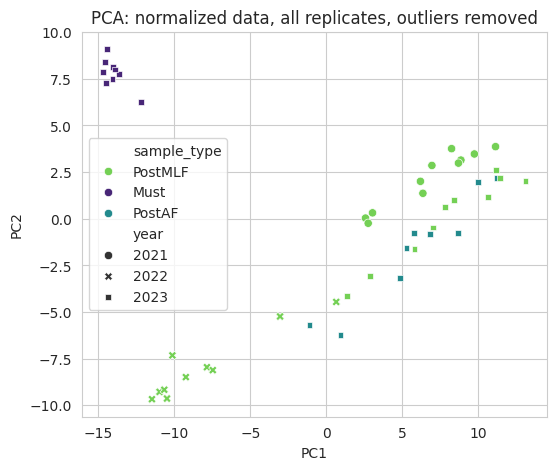

In [ ]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_MS2_wMetadata_cleaned.iloc[:, 3:])

df_pca = df_MS2_wMetadata_cleaned[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette = sample_type_palette)
plt.title('PCA: normalized data, outliers removed')
plt.show()


In [37]:
# save
df_MS2_wMetadata_cleaned.to_csv('Pos_MS2_OutlierRemoved.csv')